In [187]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [188]:
import sys

import numpy as np
import pandas as pd
import xarray as xr
import proplot as pplt
from scipy.signal import lfilter
from dynaconf import Dynaconf

settings = Dynaconf(settings_files=["settings.toml"])
sys.path.insert(0, settings.path_for("src"))
import py

In [189]:
def generate_ar1(n, phi, sigma, seed=None):
    if seed is not None:
        np.random.seed(seed)

    noise = np.random.normal(0, sigma, n)
    ar1 = lfilter([1], [1, -phi], noise)

    return ar1

In [190]:
np.random.seed(786)
dates = pd.date_range("2024-01-01", "2025-12-31")


# Seasonal cycle
def normalize(data, new_min, new_max):
    data_min = np.min(data)
    data_max = np.max(data)
    return (new_max - new_min) * (data - data_min) / (data_max - data_min) + new_min


# Seasonal cycle
min_seas = 22
max_seas = 27
seas = normalize(
    np.sin(np.linspace(-np.pi / 2, 7 / 2 * np.pi, len(dates))), min_seas, max_seas
)
tresh = seas + seas * 0.03
tresh_neg = seas - seas * 0.03

# Generate AR(1) process
phi = 0.99  # AR(1) coefficient
sigma = 0.2  # Standard deviation of the noise
sst = generate_ar1(len(dates), phi, sigma) + seas

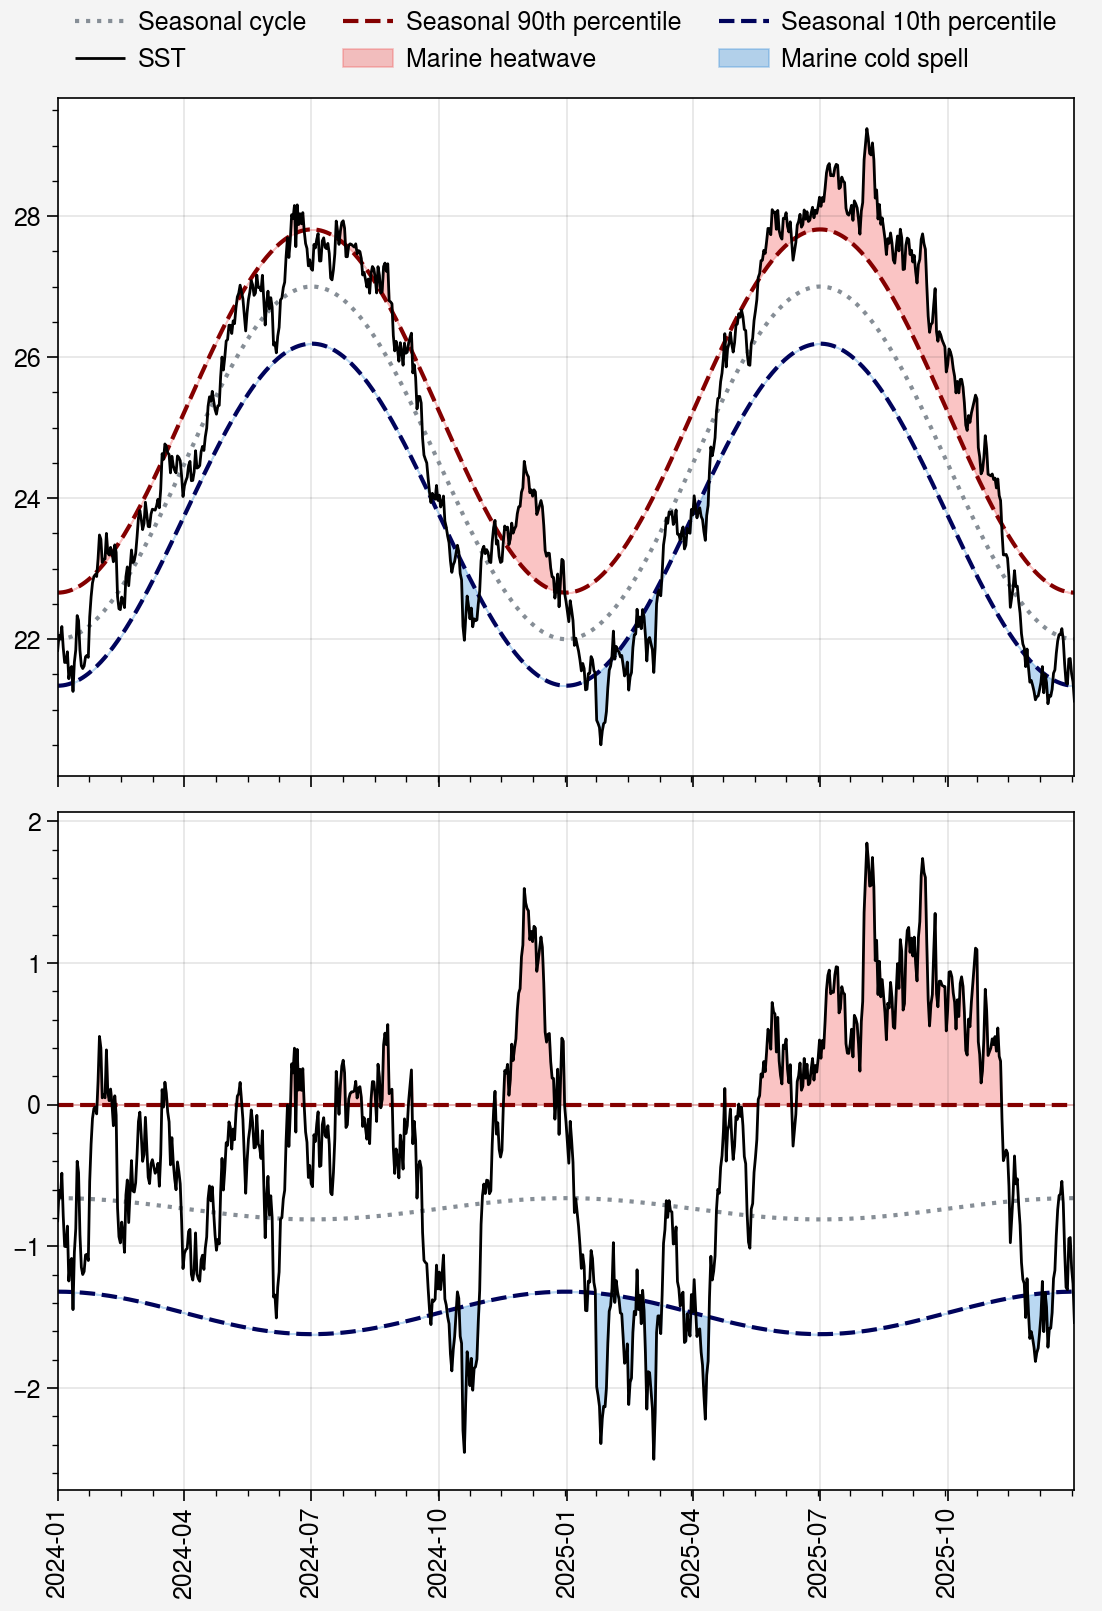

In [194]:
f, axs = pplt.subplots(nrows=2, figwidth="14cm", refaspect=1.5)
ax = axs[0]

ax.plot(dates, seas, color="gray6", label="Seasonal cycle", ls=":")
ax.plot(dates, tresh, color="dark red", label="Seasonal 90th percentile", ls="--")
ax.plot(dates, tresh_neg, color="dark blue", label="Seasonal 10th percentile", ls="--")
ax.plot(dates, sst, color="k", lw=1, label="SST")

ax.area(
    dates,
    tresh,
    np.where(sst > tresh, sst, tresh),
    color="red7",
    alpha=0.3,
    label="Marine heatwave",
)
ax.area(
    dates,
    tresh_neg,
    np.where(sst < tresh_neg, sst, tresh_neg),
    color="blue7",
    alpha=0.3,
    label="Marine cold spell",
)

ax = axs[1]

ax.plot(dates, seas - tresh, color="gray6", ls=":")
ax.plot(dates, tresh - tresh, color="dark red", ls="--")
ax.plot(
    dates,
    tresh_neg - tresh,
    color="dark blue",
    ls="--",
)
ax.plot(dates, sst - tresh, color="k", lw=1)

ax.area(
    dates,
    tresh - tresh,
    np.where(sst > tresh, sst - tresh, tresh - tresh),
    color="red7",
    alpha=0.3,
)
ax.area(
    dates,
    tresh_neg - tresh,
    np.where(sst < tresh_neg, sst - tresh, tresh_neg - tresh),
    color="blue7",
    alpha=0.3,
)

f.legend(loc="t", ncols=3, frame=False)